In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier
from matplotlib import pyplot as plt
from math import sqrt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from scipy import stats as st
from random import randrange

In [2]:
pd.options.display.max_rows = 20
pd.options.display.max_columns = 200
data = pd.read_csv('clean_hep.csv', index_col='CASEID')


In [3]:
data = data.drop(['Unnamed: 0'], axis=1)

In [4]:
data.shape

(25403, 70)

In [5]:
y = data['HEP_BILELEAKAGE']
X = data.drop(['HEP_BILELEAKAGE'], axis=1)

In [6]:
skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
fold_no=0
for train_index, test_index in skf.split(data, y):
    train = data.loc[train_index,:]
    test = data.loc[test_index,:]
    train_filename = 'train' + str(fold_no) + '.csv'
    test_filename = 'test' + str(fold_no) + '.csv' 
    train.to_csv('splits/' + train_filename, index=False)
    test.to_csv('splits/' + test_filename, index=False) 
    fold_no += 1

In [7]:
d = {}
for x in range(1,6):
    d['train{}'.format(x)] = pd.read_csv('splits/train{}.csv'.format(x), low_memory=False)
    d['test{}'.format(x)] = pd.read_csv('splits/test{}.csv'.format(x), low_memory=False)

In [8]:
dX_train = []
dy_train = []
for x in d:
    if 'train' in x:
        dX_train.append(d[x].drop(columns=['HEP_BILELEAKAGE'], axis=1))
        dy_train.append(d[x]['HEP_BILELEAKAGE'])

In [9]:
dX_test = []
dy_test = []
for x in d:
    if 'test' in x:
        dX_test.append(d[x].drop(columns=['HEP_BILELEAKAGE'], axis=1))
        dy_test.append(d[x]['HEP_BILELEAKAGE'])

rfpreds = []
xgbpreds = []
model = RandomForestClassifier(n_estimators=1250, min_samples_split=2, min_samples_leaf=8, max_features='auto', max_depth=20, bootstrap=True)
model2 = XGBClassifier(n_estimators=50, subsample=0.6, min_child_weight=10, max_depth=6, learning_rate=0.1, colsample_bytree=0.8)
for X, y, X_test in zip(dX_train, dy_train, dX_test):
    model.fit(X, y)
    model2.fit(X, y)
    rfpreds.append(model.predict_proba(X_test))
    xgbpreds.append(model2.predict_proba(X_test))

%store rfpreds
%store xgbpreds

for x in range(1,6):
    print(roc_auc_score(dy_test[x], rfpreds[x][:,1]))
    

for x in range(1,6):
    print(roc_auc_score(dy_test[x], xgbpreds[x][:,1]))

In [10]:
from tensorflow import keras
input_shape = [dX_train[1].shape[1]]
model4 = keras.models.Sequential()
model4.add(keras.layers.Flatten(input_shape=input_shape))
model4.add(keras.layers.BatchNormalization())
for _ in range(2):
    model4.add(keras.layers.Dense(1000))
    model4.add(keras.layers.BatchNormalization())
    model4.add(keras.layers.Dropout(0.8))
    model4.add(keras.layers.Activation("relu"))
model4.add(keras.layers.Dense(1, activation="sigmoid"))

opt = keras.optimizers.Adam(learning_rate=3e-4)

metrics = [keras.metrics.Recall(name='Sensitivity'), keras.metrics.TrueNegatives(name='tn'), keras.metrics.AUC(name='auc'), keras.metrics.AUC(name='prc', curve='PR')]

model4.compile(
    optimizer=opt,
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=metrics,)

early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.00001,
    restore_best_weights=True,)


In [11]:
annpreds = []
for X, y, X_test in zip(dX_train, dy_train, dX_test):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=0)
    model4.fit(X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping])
    annpreds.append(model4.predict(X_test))

Epoch 1/200
30/30 [==============================] - 3s 34ms/step - loss: 0.7096 - Sensitivity: 0.3210 - tn: 10344.0000 - auc: 0.5087 - prc: 0.0451 - val_loss: 1.7009 - val_Sensitivity: 1.0000 - val_tn: 0.0000e+00 - val_auc: 0.6286 - val_prc: 0.0641
Epoch 2/200
30/30 [==============================] - 0s 11ms/step - loss: 0.2650 - Sensitivity: 0.0688 - tn: 14066.0000 - auc: 0.5287 - prc: 0.0440 - val_loss: 1.1014 - val_Sensitivity: 1.0000 - val_tn: 16.0000 - val_auc: 0.6747 - val_prc: 0.0799
Epoch 3/200
30/30 [==============================] - 0s 12ms/step - loss: 0.2352 - Sensitivity: 0.0441 - tn: 14430.0000 - auc: 0.5334 - prc: 0.0472 - val_loss: 0.6387 - val_Sensitivity: 0.5528 - val_tn: 3499.0000 - val_auc: 0.6947 - val_prc: 0.0894
Epoch 4/200
30/30 [==============================] - 0s 11ms/step - loss: 0.2129 - Sensitivity: 0.0600 - tn: 14494.0000 - auc: 0.5682 - prc: 0.0615 - val_loss: 0.5947 - val_Sensitivity: 0.5025 - val_tn: 3836.0000 - val_auc: 0.7029 - val_prc: 0.0917
Epoch

In [12]:
ann_score = []
for x in range(0,5):
    ann_score.append(roc_auc_score(dy_test[x], annpreds[x]))
ann_score

[0.7381540667895923,
 0.7516799466418933,
 0.7832669683798719,
 0.800528775993916,
 0.772037832148239]

model.fit(dX_train[0], dy_train[0])
def rf_feat_importance(model, X):
    return pd.DataFrame({'cols':X.columns, 'imp':model.feature_importances_}
                       ).sort_values('imp', ascending=False)
fi = rf_feat_importance(model, X)
fi[:10]
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:20]);

model2.fit(dX_train[0], dy_train[0])
fi = rf_feat_importance(model2, X)
plot_fi(fi[:20]);

In [13]:
lrpreds = []
model3 = LogisticRegression()
for X, y, X_test in zip(dX_train, dy_train, dX_test):
    model3.fit(X, y)
    lrpreds.append(model3.predict_proba(X_test))

/home/kchen/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/kchen/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

In [14]:
lr_score = []
for x in range(0,5):
    lr_score.append(roc_auc_score(dy_test[x], lrpreds[x][:,1]))

In [15]:
ann_mean = np.mean(ann_score)
ann_confidence = st.t.interval(0.95, len(ann_score)-1, loc=ann_mean, scale=st.sem(ann_score))

print('Neural Network:', round(ann_mean,3), '('+str(round(ann_confidence[0],3))+'-'+str(round(ann_confidence[1],3))+')')

Neural Network: 0.769 (0.738-0.8)


In [16]:
lr_mean = np.mean(lr_score)
lr_confidence = st.t.interval(0.95, len(lr_score)-1, loc=lr_mean, scale=st.sem(lr_score))

print('Logistic Regression:', round(lr_mean,3), '('+str(round(lr_confidence[0],3))+'-'+str(round(lr_confidence[1],3))+')')

Logistic Regression: 0.724 (0.703-0.745)


In [17]:
ann_prc = []
for x in range(0,5):
    ann_prc.append(average_precision_score(dy_test[x], annpreds[x]))

ann_prc_mean = np.mean(ann_prc)
ann_prc_confidence = st.t.interval(0.95, len(ann_prc)-1, loc=ann_prc_mean, scale=st.sem(ann_prc))

print('Neural Network:', round(ann_prc_mean,3), '('+str(round(ann_prc_confidence[0],3))+'-'+str(round(ann_prc_confidence[1],3))+')')

Neural Network: 0.149 (0.107-0.19)


In [18]:
lr_prc = []
for x in range(0,5):
    lr_prc.append(average_precision_score(dy_test[x], lrpreds[x][:,1]))

lr_prc_mean = np.mean(lr_prc)
lr_prc_confidence = st.t.interval(0.95, len(lr_prc)-1, loc=lr_prc_mean, scale=st.sem(lr_prc))

print('Logistic Regression:', round(lr_prc_mean,3), '('+str(round(lr_prc_confidence[0],3))+'-'+str(round(lr_prc_confidence[1],3))+')')

Logistic Regression: 0.097 (0.086-0.108)


In [19]:
with open('hep_results.txt', 'w') as f:
    f.write('Logistic Regression: '+str(round(lr_mean,3))+' ('+str(round(lr_confidence[0],3))+'-'+str(round(lr_confidence[1],3))+')\n')
    f.write('Neural Network: '+str(round(ann_mean,3))+' ('+str(round(ann_confidence[0],3))+'-'+str(round(ann_confidence[1],3))+')\n')
    f.write('AUPRC\n')
    f.write('Logistic Regression: '+str(round(lr_prc_mean,3))+' ('+str(round(lr_prc_confidence[0],3))+'-'+str(round(lr_prc_confidence[1],3))+')\n')
    f.write('Neural Network: '+str(round(ann_prc_mean,3))+' ('+str(round(ann_prc_confidence[0],3))+'-'+str(round(ann_prc_confidence[1],3))+')')

In [20]:
hep_ann_tpr = []
hep_ann_fpr = []
for x in range(0,5):
    fpr, tpr, _ = roc_curve(dy_test[x], annpreds[x])
    hep_ann_tpr.append(tpr)
    hep_ann_fpr.append(fpr)


In [21]:
for x in range(0,5):
    print(len(hep_ann_tpr[x]))

370
316
362
353
352


In [22]:
for x in range(0,5):
    diff = len(hep_ann_tpr[x]) - 310
    for _ in range(diff):
        ind = randrange(len(hep_ann_tpr[x]))
        hep_ann_tpr[x] = np.delete(hep_ann_tpr[x],ind)
for x in range(0,5):
    diff = len(hep_ann_fpr[x]) - 310
    for _ in range(diff):
        ind = randrange(len(hep_ann_fpr[x]))
        hep_ann_fpr[x] = np.delete(hep_ann_fpr[x],ind)


mean_hep_ann_tpr = [np.mean(k) for k in zip(*hep_ann_tpr)]
mean_hep_ann_fpr = [np.mean(k) for k in zip(*hep_ann_fpr)]
%store mean_hep_ann_tpr
%store mean_hep_ann_fpr


Stored 'mean_hep_ann_tpr' (list)
Stored 'mean_hep_ann_fpr' (list)


In [23]:

hep_lr_tpr = []
hep_lr_fpr = []
for x in range(0,5):
    fpr, tpr, _ = roc_curve(dy_test[x], lrpreds[x][:,1])
    hep_lr_tpr.append(tpr)
    hep_lr_fpr.append(fpr)
for x in range(0,5):
    diff = len(hep_lr_tpr[x]) - 310
    for _ in range(diff):
        ind = randrange(len(hep_lr_tpr[x]))
        hep_lr_tpr[x] = np.delete(hep_lr_tpr[x],ind)

for x in range(0,5):
    diff = len(hep_lr_fpr[x]) - 310
    for _ in range(diff):
        ind = randrange(len(hep_lr_fpr[x]))
        hep_lr_fpr[x] = np.delete(hep_lr_fpr[x],ind)


mean_hep_lr_tpr = [np.mean(k) for k in zip(*hep_lr_tpr)]
mean_hep_lr_fpr = [np.mean(k) for k in zip(*hep_lr_fpr)]
%store mean_hep_lr_tpr
%store mean_hep_lr_fpr


Stored 'mean_hep_lr_tpr' (list)
Stored 'mean_hep_lr_fpr' (list)


In [24]:

hep_lr_rec = []
hep_lr_prec = []
for x in range(0,5):
    prec, rec, _ = precision_recall_curve(dy_test[x], lrpreds[x][:,1])
    hep_lr_rec.append(rec)
    hep_lr_prec.append(prec)


In [25]:
for x in range(0,5):
    print(len(hep_lr_rec[x]))

4970
4982
4866
5047
5047


In [26]:

for x in range(0,5):
    diff = len(hep_lr_rec[x]) - 4800
    for _ in range(diff):
        ind = randrange(len(hep_lr_rec[x]))
        hep_lr_rec[x] = np.delete(hep_lr_rec[x],ind)

for x in range(0,5):
    diff = len(hep_lr_prec[x]) - 4800
    for _ in range(diff):
        ind = randrange(len(hep_lr_prec[x]))
        hep_lr_prec[x] = np.delete(hep_lr_prec[x],ind)

mean_hep_lr_rec = [np.mean(k) for k in zip(*hep_lr_rec)]
mean_hep_lr_prec = [np.mean(k) for k in zip(*hep_lr_prec)]
%store mean_hep_lr_rec
%store mean_hep_lr_prec


Stored 'mean_hep_lr_rec' (list)
Stored 'mean_hep_lr_prec' (list)


In [28]:
from matplotlib import pyplot as plt

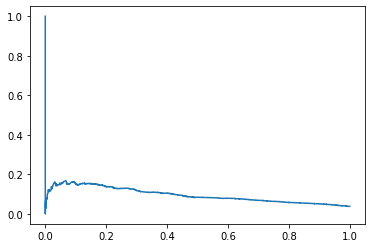

In [29]:
plt.plot(mean_hep_lr_rec, mean_hep_lr_prec)

In [27]:

hep_ann_rec = []
hep_ann_prec = []
for x in range(0,5):
    prec, rec, _ = precision_recall_curve(dy_test[x], annpreds[x])
    hep_ann_rec.append(rec)
    hep_ann_prec.append(prec)

for x in range(0,5):
    diff = len(hep_ann_rec[x]) - 4500
    for _ in range(diff):
        ind = randrange(len(hep_ann_rec[x]))
        hep_ann_rec[x] = np.delete(hep_ann_rec[x],ind)

for x in range(0,5):
    diff = len(hep_ann_prec[x]) - 4500
    for _ in range(diff):
        ind = randrange(len(hep_ann_prec[x]))
        hep_ann_prec[x] = np.delete(hep_ann_prec[x],ind)

mean_hep_ann_rec = [np.mean(k) for k in zip(*hep_ann_rec)]
mean_hep_ann_prec = [np.mean(k) for k in zip(*hep_ann_prec)]
%store mean_hep_ann_rec
%store mean_hep_ann_prec

Stored 'mean_hep_ann_rec' (list)
Stored 'mean_hep_ann_prec' (list)


hep_ann_tpr = []
hep_ann_fpr = []
for x in range(0,5):
    fpr, tpr, _ = roc_curve(dy_test[x], annpreds[x])
    hep_ann_tpr.append(tpr)
    hep_ann_fpr.append(fpr)
hep_ann_tpr_array = [np.array(x) for x in hep_ann_tpr]
mean_hep_ann_tpr = [np.mean(k) for k in zip(*hep_ann_tpr_array)]
hep_ann_fpr_array = [np.array(x) for x in hep_ann_fpr]
mean_hep_ann_fpr = [np.mean(k) for k in zip(*hep_ann_fpr_array)]
%store mean_hep_ann_tpr
%store mean_hep_ann_fpr

hep_lr_tpr = []
hep_lr_fpr = []
for x in range(0,5):
    fpr, tpr, _ = roc_curve(dy_test[x], lrpreds[x][:,1])
    hep_lr_tpr.append(tpr)
    hep_lr_fpr.append(fpr)
hep_lr_tpr_array = [np.array(x) for x in hep_lr_tpr]
mean_hep_lr_tpr = [np.mean(k) for k in zip(*hep_lr_tpr_array)]
hep_lr_fpr_array = [np.array(x) for x in hep_lr_fpr]
mean_hep_lr_fpr = [np.mean(k) for k in zip(*hep_lr_fpr_array)]
%store mean_hep_lr_tpr
%store mean_hep_lr_fpr
hep_ann_rec = []
hep_ann_prec = []
for x in range(0,5):
    prec, rec, _ = precision_recall_curve(dy_test[x], annpreds[x])
    hep_ann_rec.append(rec)
    hep_ann_prec.append(prec)
hep_ann_rec_array = [np.array(x) for x in hep_ann_rec]
mean_hep_ann_rec = [np.mean(k) for k in zip(*hep_ann_rec_array)]
hep_ann_prec_array = [np.array(x) for x in hep_ann_prec]
mean_hep_ann_prec = [np.mean(k) for k in zip(*hep_ann_prec_array)]
%store mean_hep_ann_rec
%store mean_hep_ann_prec

hep_lr_rec = []
hep_lr_prec = []
for x in range(0,5):
    prec, rec, _ = precision_recall_curve(dy_test[x], lrpreds[x][:,1])
    hep_lr_rec.append(rec)
    hep_lr_prec.append(prec)
hep_lr_rec_array = [np.array(x) for x in hep_lr_rec]
mean_hep_lr_rec = [np.mean(k) for k in zip(*hep_lr_rec_array)]
hep_lr_prec_array = [np.array(x) for x in hep_lr_prec]
mean_hep_lr_prec = [np.mean(k) for k in zip(*hep_lr_prec_array)]
%store mean_hep_lr_rec
%store mean_hep_lr_prec
